# Feature Extraction

#### Dependencies

In [1]:
import pm4py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

#### Event Log Import

In [2]:
non_conforming_log_df = pd.read_pickle("filtered-non-conforminlog.pkl")

#### Normative Model Import

In [ ]:
file_path = r""
normative_petri_net = pm4py.read_pnml(file_path)

## Feature Extraction from Log

In [4]:
features_df = pm4py.extract_features_dataframe(
    non_conforming_log_df,
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp',
    str_tr_attr=[], 	
    num_tr_attr=["Amount", "RequestedAmount", "OriginalAmount", "Permit RequestedBudget", "AdjustedAmount"],
    str_ev_attr=['org:role'],
    include_case_id=True
)

In [5]:
trace_attributes_df = non_conforming_log_df.groupby("case:concept:name").agg({
    "case:Permit BudgetNumber": "first",
    "case:Permit OrganizationalEntity": "first", 
    "case:Permit ProjectNumber": "first", 
    "case:BudgetNumber": "first"
}).reset_index()

features_df["case:concept:name"] = trace_attributes_df["case:concept:name"]
features_tr_att_df = pd.merge(features_df, trace_attributes_df, on="case:concept:name", how="left")


In [6]:
frequency_table = non_conforming_log_df.groupby(["case:concept:name", "concept:name"]).size().unstack(fill_value=0)
frequency_table = frequency_table.reset_index()

features_freq_df = pd.merge(features_tr_att_df, frequency_table, on="case:concept:name", how="left")

## Performance Metrics

### Fitness

In [8]:
from pm4py.objects.conversion.log import converter as log_converter

fitness_scores = []

for case_id in features_freq_df["case:concept:name"]:
    trace_df = non_conforming_log_df[non_conforming_log_df["case:concept:name"] == case_id]

    sublog = log_converter.apply(trace_df, variant=log_converter.Variants.TO_EVENT_LOG)

    fitness = pm4py.fitness_token_based_replay(
    sublog,
    normative_petri_net[0],
    normative_petri_net[1],
    normative_petri_net[2],
    activity_key='concept:name',
    case_id_key='case:concept:name',
    timestamp_key='time:timestamp'
    )

    fitness_value = fitness.get("average_trace_fitness")
    fitness_scores.append((case_id, fitness_value))

fitness_df = pd.DataFrame(fitness_scores, columns=["case:concept:name", "token_fitness"])

features_fit_df = features_freq_df.merge(fitness_df, on="case:concept:name", how="left")


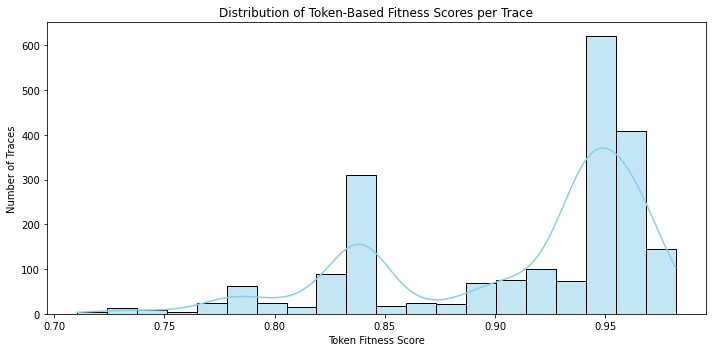

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(features_fit_df["token_fitness"], bins=20, kde=True, color="skyblue")

plt.title("Distribution of Token-Based Fitness Scores per Trace")
plt.xlabel("Token Fitness Score")
plt.ylabel("Number of Traces")
plt.tight_layout()
plt.show()

### Trace Duration & Event Count

In [10]:
trace_duration_df = non_conforming_log_df.groupby("case:concept:name")["time:timestamp"].agg(
    trace_start="min",
    trace_end="max"
).reset_index()

trace_duration_df["trace_duration_days"] = (trace_duration_df["trace_end"] - trace_duration_df["trace_start"]).dt.total_seconds() / (60 * 60 * 24)

trace_event_count_df = non_conforming_log_df.groupby("case:concept:name").size().reset_index(name="num_events")

features_duration_df = features_fit_df.merge(trace_duration_df[["case:concept:name", "trace_duration_days"]], on="case:concept:name", how="left")
features_ev_count_df = features_duration_df.merge(trace_event_count_df, on="case:concept:name", how="left")

In [11]:
features_ev_count_df.head()

,case:concept:name,case:AdjustedAmount,case:OriginalAmount,org:role_EMPLOYEE,org:role_ADMINISTRATION,org:role_SUPERVISOR,org:role_UNDEFINED,org:role_BUDGETOWNER,org:role_DIRECTOR,org:role_MISSING,...,Permit REJECTED by MISSING,Permit REJECTED by PRE_APPROVER,Permit REJECTED by SUPERVISOR,Permit SUBMITTED by EMPLOYEE,Request Payment,Send Reminder,Start trip,token_fitness,trace_duration_days,num_events
0,declaration 10069,71.195831,71.195831,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,1,1,0,1,0.958333,8.043854,10
1,declaration 10089,3146.344971,3146.344971,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,1,1,0,1,0.969697,97.312303,13
2,declaration 10455,586.435608,586.435608,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,1,2,1,0,1,0.974359,40.138924,17
3,declaration 10472,679.303223,679.303223,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,1,1,0,1,0.869565,14.404468,12
4,declaration 10552,997.438721,997.438721,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0,0,0,2,1,0,1,0.957447,62.796690,19
